In [1]:
import numpy as np
import h5py
import xarray as xr
import torch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path

from aurora.batch import Batch, Metadata
from aurora.model.aurora_lite import AuroraLite
from aurora.model.decoder_lite import MLPDecoderLite

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

This section follows the procedure described on [Aurora webpage](https://microsoft.github.io/aurora/example_era5.html). You need an account on [Climate Data Store](https://cds.climate.copernicus.eu/) and follow the instructions of the `cdsapi` package. 

In [2]:
# Data will be downloaded here.
download_path = Path("./data/downloads")

## Data download

The following cell first downloads input data for Aurora and then downloads the hydrological data to evaluate the decoders predictions.

In [ ]:
import cdsapi

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2020",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2020-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2020",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2020-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2020-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2020",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2020-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")


# Download the surface-level hydrological variables.
if not (download_path / "2020-01-01-hydrological.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "total_precipitation",
                "potential_evaporation",
                "runoff",
                "volumetric_soil_water_layer_1",
                "volumetric_soil_water_layer_2",
                "volumetric_soil_water_layer_3",
            ],
            "year": "2020",
            "month": "01",
            "day": "01",
            "time": ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", 
                     "06:00", "07:00", "08:00", "09:00", "10:00", "11:00",
                     "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", 
                     "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"],
            "format": "netcdf",
        },
        str(download_path / "2020-01-01-hydrological.nc"),
    )
print("Hydrological variables downloaded!")

## Prepare input batch

In [3]:
static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
static_vars_ds = static_vars_ds.sel(latitude=static_vars_ds.latitude[:720])
surf_vars_ds = xr.open_dataset(download_path / "2020-01-01-surface-level.nc", engine="netcdf4")
surf_vars_ds = surf_vars_ds.sel(latitude=surf_vars_ds.latitude[:720])
atmos_vars_ds = xr.open_dataset(download_path / "2020-01-01-atmospheric.nc", engine="netcdf4")
atmos_vars_ds = atmos_vars_ds.sel(latitude=atmos_vars_ds.latitude[:720])

batch = Batch(
    surf_vars={
        # First select the first two time points: 00:00 and 06:00. Afterwards, `[None]`
        # inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[:2][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[:2][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[:2][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[:2][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[:2][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[:2][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[:2][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[:2][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[:2][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

# Initialize and load the model

Define the model with additional variables

In [4]:
# New surface variables predicted by the decoders
surf_vars_new = ["tp_mswep", # total precipitation MSWEP
                "pe", # potential evaporation
                "r", # runoff
                "swc", # soil water content,
                "tws_gou", # terrestrial water storage
                ]

dict_vars = {'surf_vars': ("2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure", "total_precipitation_MSWEP", "potential_evaporation", "runoff", "soil_water_content"),
            'static_vars': ("land_sea_mask", "geopotential_at_surface", "soil_type"),
            'atmos_vars': ("geopotential", "u_component_of_wind", "v_component_of_wind", "temperature", "specific_humidity")}

aurora_vars_abr = {'surf_vars': ("2t", "10u", "10v", "msl", "tp_mswep", "pe", "r", "swc"),
                'static_vars': ("lsm", "z", "slt"),
                'atmos_vars': ("z", "u", "v", "t", "q")}

Define the Aurora model. The addition of the `AuroraLite` class is to output the latent variable in addition to the spatial output maps.

In [5]:
modelAurora = AuroraLite(
    use_lora=False, 
    autocast=True, #Use AMP (mixed precision to fit to gpu)
    surf_vars=("2t", "10u", "10v", "msl"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"))

modelAurora.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
modelAurora = modelAurora.to("cuda")
modelAurora.eval()

AuroraLite(
  (encoder): Perceiver3DEncoder(
    (surf_mlp): MLP(
      (net): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (surf_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (pos_embed): Linear(in_features=512, out_features=512, bias=True)
    (scale_embed): Linear(in_features=512, out_features=512, bias=True)
    (lead_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (absolute_time_embed): Linear(in_features=512, out_features=512, bias=True)
    (atmos_levels_embed): Linear(in_features=512, out_features=512, bias=True)
    (surf_token_embeds): LevelPatchEmbed(
      (weights): ParameterDict(
          (10u): Parameter containing: [torch.cuda.FloatTensor of size 512x1x2x4x4 (cuda:0)]
          (10v): Parameter containing: [torch.cuda.FloatTensor of

Define the decoders: one for each new surface variable `surf_vars_new`.

In [ ]:
modelDecoder = MLPDecoderLite(surf_vars_new=surf_vars_new, 
                                        patch_size=modelAurora.decoder.patch_size, 
                                        embed_dim=2*modelAurora.encoder.embed_dim,
                                        hidden_dims=[512, 512, 256],
                                        )
checkpoint = torch.load("./lite-decoder.ckpt")
modelDecoder.load_state_dict(checkpoint)
modelDecoder.to("cuda")
modelDecoder.eval()

MLPDecoderLite(
  (surf_heads): ParameterDict(
      (pe): Object of type: MLP
      (r): Object of type: MLP
      (swc): Object of type: MLP
      (tp_mswep): Object of type: MLP
      (tws_gou): Object of type: MLP
    (pe): MLP(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.0, inplace=False)
      (9): Linear(in_features=256, out_features=16, bias=True)
      (10): Dropout(p=0.0, inplace=False)
    )
    (r): MLP(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0, inplace=False)
      (6): Linear(in_feat

## Make predictions and plot output maps

In [11]:
import matplotlib as mpl
from transform_data import transform_data

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        #x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [8]:
with torch.inference_mode():
    preds_org, lat_dec = modelAurora.forward(batch)
    latent_decoder = lat_dec.detach().clone()
    preds_new = modelDecoder.forward(latent_decoder, batch.metadata.lat, batch.metadata.lon)

# the decoders predict transformed data (e.g., log-transformed precipitation). This transform is removed in the following line
preds_new = {k: transform_data(v.cpu().numpy().squeeze(), k, direct=False) for k,v in preds_new.items()}

In [10]:
hydro_vars_ds = xr.open_dataset(download_path / "2020-01-01-hydrological.nc", engine="netcdf4")
hydro_vars_ds = hydro_vars_ds.sel(latitude=hydro_vars_ds.latitude[:720])

Total precipitation (6-hour accumulation). The decoders were trained on the MSWEP dataset, which is why predictions are not compared with total precipitation from ERA5.

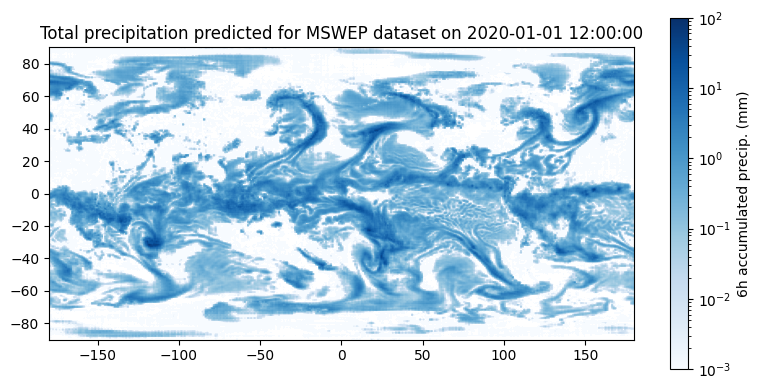

In [50]:
k = 'tp_mswep'

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(1e3*preds_new[k], extent=(-180, 180, -90, 90), cmap=plt.get_cmap("Blues"), 
               norm=mpl.colors.LogNorm(vmin=1e-3, vmax=100))
fig.colorbar(im, ax=ax, label='6h accumulated precip. (mm)')
ax.set_title(f'Total precipitation predicted for MSWEP dataset on {preds_org.metadata.time[0]}')
fig.tight_layout()
plt.show()

Potential evaporation (6-hour accumulation)

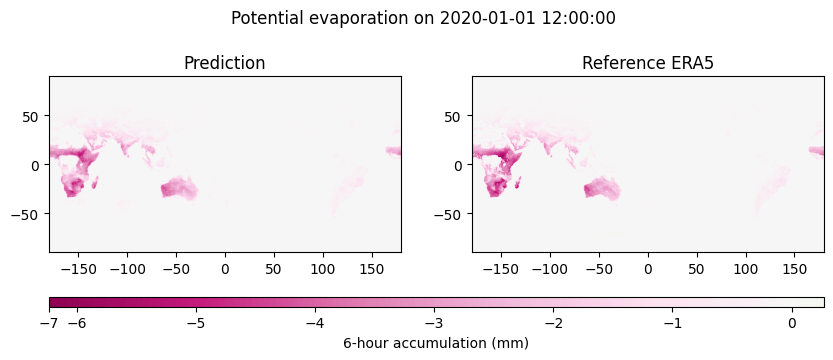

In [49]:
k = 'pe'

fig, axs = plt.subplots(1, 2, figsize=(10,3.2))
# Accumulate potential evaporation over a 6-hour time window and convert meters to millimeters
target = 1e3*hydro_vars_ds['pev'].sel(valid_time=slice(preds_org.metadata.time[0] - timedelta(hours=5), preds_org.metadata.time[0])).sum(dim='valid_time')
vmin, vmax = np.min(target), np.max(target)
im = axs[0].imshow(1e3*preds_new[k], norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0), 
                   cmap=plt.get_cmap('PiYG'), extent=(-180, 180, -90, 90))
axs[0].set_title('Prediction')

im = axs[1].imshow(target, norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0), 
                   cmap=plt.get_cmap('PiYG'), extent=(-180, 180, -90, 90))
axs[1].set_title('Reference ERA5')
cax = plt.axes([axs[0].get_position().xmin, 0.05, axs[1].get_position().xmax - axs[0].get_position().xmin, 0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', label='6-hour accumulation (mm)')

fig.suptitle(f'Potential evaporation on {preds_org.metadata.time[0]}')
plt.show()

Runoff

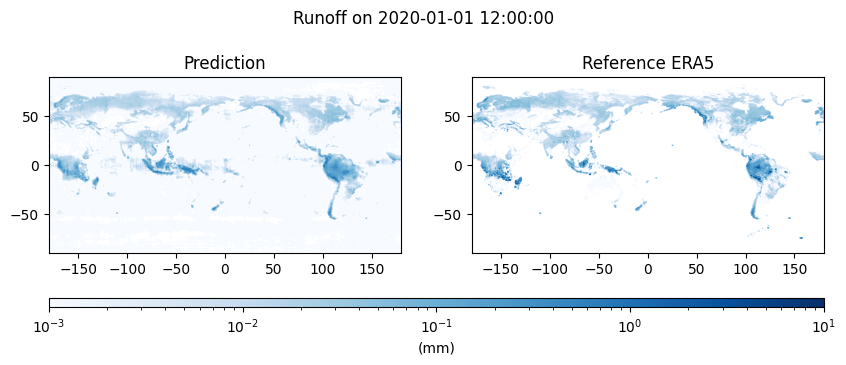

In [53]:
k = 'r'

fig, axs = plt.subplots(1, 2, figsize=(10,3.2))
target = 1e3*hydro_vars_ds['ro'].sel(valid_time=preds_org.metadata.time[0]) # convert meters to millimeters
im = axs[0].imshow(1e3*preds_new[k], extent=(-180, 180, -90, 90), cmap=plt.get_cmap("Blues"), 
                   norm=mpl.colors.LogNorm(vmin=1e-3, vmax=10))
axs[0].set_title('Prediction')

im = axs[1].imshow(target, extent=(-180, 180, -90, 90), cmap=plt.get_cmap("Blues"), 
                   norm=mpl.colors.LogNorm(vmin=1e-3, vmax=10))
axs[1].set_title('Reference ERA5')
cax = plt.axes([axs[0].get_position().xmin, 0.05, axs[1].get_position().xmax - axs[0].get_position().xmin, 0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', label='(mm)')

fig.suptitle(f'Runoff on {preds_org.metadata.time[0]}')
plt.show()

Soil water content (weighted sum of `volumetric_soil_water_layer` down to 1 meter)

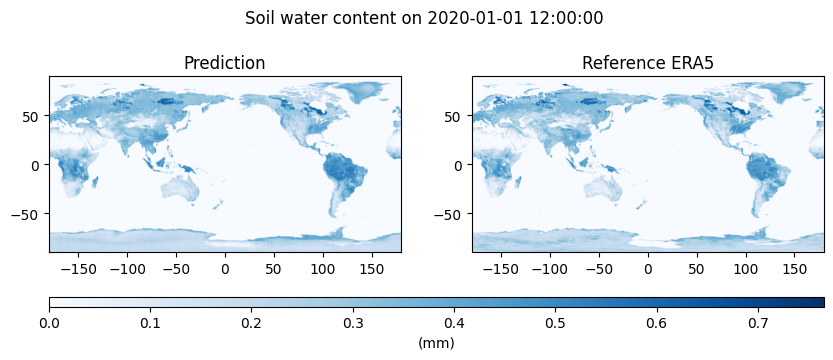

In [ ]:
k = 'swc'

fig, axs = plt.subplots(1, 2, figsize=(10,3.2))
target = 0.07*hydro_vars_ds["swvl_1"].sel(valid_time=preds_org.metadata.time[0]).values + \
            0.21*hydro_vars_ds["swvl_2"].sel(valid_time=preds_org.metadata.time[0]).values + \
            0.72*hydro_vars_ds["swvl_3"].sel(valid_time=preds_org.metadata.time[0]).values

im = axs[0].imshow(preds_new[k], extent=(-180, 180, -90, 90), cmap=plt.get_cmap("Blues"), 
                   vmin=0, vmax=np.max(target))
axs[0].set_title('Prediction')

im = axs[1].imshow(target, extent=(-180, 180, -90, 90), cmap=plt.get_cmap("Blues"), 
                   vmin=0, vmax=np.max(target))
axs[1].set_title('Reference ERA5')
cax = plt.axes([axs[0].get_position().xmin, 0.05, axs[1].get_position().xmax - axs[0].get_position().xmin, 0.03])
fig.colorbar(im, cax=cax, orientation='horizontal', label='(mm)')

fig.suptitle(f'Soil water content on {preds_org.metadata.time[0]}')
plt.show()